### This is a self-driving car project to detect vehicle on the road!

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

In [10]:
cars_far = glob.glob('./vehicles/GTI_Far/*.png')
cars_middle = glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars_left = glob.glob('./vehicles/GTI_Left/*.png')
cars_right = glob.glob('./vehicles/GTI_Right/*.png')
cars_extracted = glob.glob('./vehicles/KITTI_extracted/*.png')

In [11]:
notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars += glob.glob('./non-vehicles/GTI/*.png')

In [13]:
cars=cars_far+cars_middle+cars_left+cars_right+cars_extracted

In [14]:
len(cars)

8792

In [17]:
len(notcars)

8968

### Firstly, we need to store all the image data into .p file so that we can get data more easily

I am planning to set 80% as the training data and 20% as the data set 

In [18]:
pickle_file = 'data.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'cars': cars,
                'notcars': notcars
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Saving data to pickle file...


In [16]:
datafile = 'data.p'
with open(datafile, mode='rb') as f:
    data = pickle.load(f)

Over here, split data into training test set and test data set

In [17]:
cars_data=data['cars']
notcars_data=data['notcars']
cars_train,cars_test=train_test_split(cars_data,test_size=0.2)
notcars_train,notcars_test=train_test_split(notcars_data,test_size=0.2)

We need to create a function used to get features from images

In [18]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Let's see a simple demo how to get Histogram of Oriented Gradients

In [12]:
%matplotlib inline
pix_per_cell=8
cell_per_block=2
orient=9
img=cars_train[0]
img=mpimg.imread(img)
demo_features=[]
hog_image_demo=[]
for channel in range(img.shape[2]):
    features,hog_image=get_hog_features(img[:,:,channel], orient, pix_per_cell,\
                                        cell_per_block, vis=True, feature_vec=True)
    demo_features.append(features)
    hog_image_demo.append(hog_image)

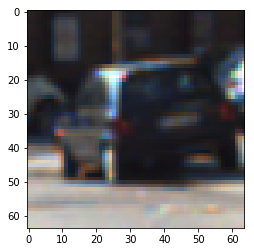

In [13]:
plt.imshow(img)

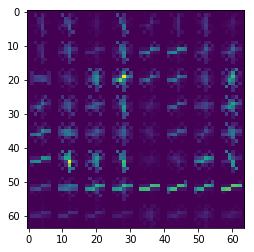

In [15]:
plt.imshow(hog_image_demo[0])

In [22]:
demo_features[0].shape

(1764,)

In [23]:
feature_training_cars=[]
for file in cars_train:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='RGB', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_cars.append(img_features)

feature_testing_cars=[]
for file in cars_test:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='RGB', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_cars.append(img_features)

feature_training_notcars=[]
for file in notcars_train:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='RGB', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_notcars.append(img_features)

feature_testing_notcars=[]
for file in notcars_test:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='RGB', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_notcars.append(img_features)


### Now features have been extracted, now we need to use SVM to explore data

In [53]:
# Create an array stack of feature vectors
X = np.vstack((feature_training_cars,feature_training_notcars)).astype(np.float64)  
y_train = np.hstack((np.ones(len(feature_training_cars)), np.zeros(len(feature_training_notcars))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
X_train=scaled_X

In [62]:
X_train[0].shape

(4932,)

In [56]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("the time for fitting:{}".format(t2-t))

the time for fitting:16.30732536315918


In [57]:
X_test = np.vstack((feature_testing_cars,feature_testing_notcars)).astype(np.float64)  
y_testing = np.hstack((np.ones(len(feature_testing_cars)), np.zeros(len(feature_testing_notcars))))
X_test_scaler = StandardScaler().fit(X_test)
X_testing = X_test_scaler.transform(X_test)

In [63]:
X_testing[0].shape

(4932,)

Now we can use our classifier to test accuracy on our test data set

In [59]:
print('Test Accuracy of SVC = ', round(svc.score(X_testing, y_testing), 4))

Test Accuracy of SVC =  0.9679


## Then, we need to construct a function to search windows

In [60]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [66]:
# Define a function to return HOG features and visualization
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [72]:
color_space = 'RGB'
spatial_size = (32,32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_feat = True
hist_feat = True
hog_feat = True

In [118]:
#Got an idea from the forum and referenced some codes from there
def get_rectangle_cars(image):
    hot_windows = []
    all_windows = []
    
    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    #w0,w1,w2,w3 = 240,180,120,70
    #o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    XY_window = [(240,240),(180,180),[120,120],[70,70]]
    XY_overlap = [(0.75,0.75),(0.75,0.75),(0.75,0.75),(0.75,0.75)]
    #yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_start_stop =[[380,655],[380,655],[380,655],[405,655]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

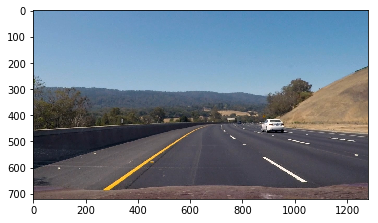

In [119]:
test_image=mpimg.imread("test_images/test3.jpg")
plt.imshow(test_image)

In [120]:
hot_windows,all_windows=get_rectangle_cars(test_image)

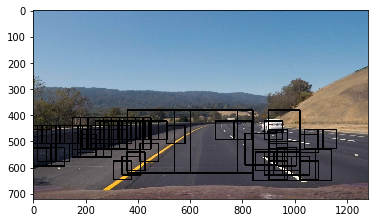

In [121]:
draw_image = np.copy(test_image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4) 
plt.imshow(window_img)

In [83]:
all_windows

[[], [], [], []]